In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from datetime import date
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from prophet.serialize import model_to_json, model_from_json
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_cross_validation_metric, plot_components_plotly, add_changepoints_to_plot, plot_yearly
from prophet.serialize import model_to_json, model_from_json

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
#!unzip household_power_consumption.zip

In [3]:
pd.set_option("display.float_format", "{:.2f}".format)

In [4]:
# The ds (datestamp) column should be of a format expected by Pandas,
# ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

In [5]:
df = pd.read_csv("household_power_consumption.txt", sep=";", parse_dates={'ds':['Date', 'Time']}, na_values=['nan', '?'], infer_datetime_format=True, low_memory=False)
del df['Sub_metering_1']
del df['Sub_metering_2']
del df['Sub_metering_3']
del df['Global_reactive_power']
del df['Voltage']
del df['Global_intensity']
df.rename(columns={'Global_active_power':'y'}, inplace = True)
df

ds    y
0       2006-12-16 17:24:00 4.22
1       2006-12-16 17:25:00 5.36
2       2006-12-16 17:26:00 5.37
3       2006-12-16 17:27:00 5.39
4       2006-12-16 17:28:00 3.67
...                     ...  ...
2075254 2010-11-26 20:58:00 0.95
2075255 2010-11-26 20:59:00 0.94
2075256 2010-11-26 21:00:00 0.94
2075257 2010-11-26 21:01:00 0.93
2075258 2010-11-26 21:02:00 0.93

[2075259 rows x 2 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ds      datetime64[ns]
 1   y       float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.7 MB


In [7]:
df

ds    y
0       2006-12-16 17:24:00 4.22
1       2006-12-16 17:25:00 5.36
2       2006-12-16 17:26:00 5.37
3       2006-12-16 17:27:00 5.39
4       2006-12-16 17:28:00 3.67
...                     ...  ...
2075254 2010-11-26 20:58:00 0.95
2075255 2010-11-26 20:59:00 0.94
2075256 2010-11-26 21:00:00 0.94
2075257 2010-11-26 21:01:00 0.93
2075258 2010-11-26 21:02:00 0.93

[2075259 rows x 2 columns]

In [8]:
df.isna().sum()

ds        0
y     25979
dtype: int64

In [9]:
df.describe(include='all').T

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\377021028.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T


count   unique                 top freq               first  \
ds    2075259  2075259 2006-12-16 17:24:00    1 2006-12-16 17:24:00   
y  2049280.00      NaN                 NaT  NaN                 NaT   

                  last mean  std  min  25%  50%  75%   max  
ds 2010-11-26 21:02:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
y                  NaT 1.09 1.06 0.08 0.31 0.60 1.53 11.12

In [10]:
df = df.fillna(df.shift(60*24*7))

In [11]:
df.isna().sum()

ds    0
y     3
dtype: int64

In [12]:
df = df.fillna(df.shift(60*24*7))

In [13]:
df.isna().sum()

ds    0
y     2
dtype: int64

In [14]:
df = df.fillna(df.shift(60*24))

In [15]:
df.isna().sum()

ds    0
y     0
dtype: int64

In [16]:
df.describe(include='all').T

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\377021028.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T


count   unique                 top freq               first  \
ds    2075259  2075259 2006-12-16 17:24:00    1 2006-12-16 17:24:00   
y  2075259.00      NaN                 NaT  NaN                 NaT   

                  last mean  std  min  25%  50%  75%   max  
ds 2010-11-26 21:02:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
y                  NaT 1.09 1.06 0.08 0.31 0.60 1.53 11.12

In [17]:
df["y"] = df["y"].apply(lambda x: x/60)

In [18]:
df_H = df.resample('H', on="ds").mean()
df_H= df_H.reset_index(drop=False)
df_H.head()

ds    y
0 2006-12-16 17:00:00 0.07
1 2006-12-16 18:00:00 0.06
2 2006-12-16 19:00:00 0.06
3 2006-12-16 20:00:00 0.05
4 2006-12-16 21:00:00 0.05

## (General) Morning: 5:00 - 9:00

In [19]:
df_morning = df_H[df_H['ds'].dt.hour > 4][df_H['ds'].dt.hour < 10]
df_morning

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\2088857711.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_morning = df_H[df_H['ds'].dt.hour > 4][df_H['ds'].dt.hour < 10]


ds    y
12    2006-12-17 05:00:00 0.03
13    2006-12-17 06:00:00 0.02
14    2006-12-17 07:00:00 0.03
15    2006-12-17 08:00:00 0.03
16    2006-12-17 09:00:00 0.04
...                   ...  ...
34572 2010-11-26 05:00:00 0.00
34573 2010-11-26 06:00:00 0.02
34574 2010-11-26 07:00:00 0.05
34575 2010-11-26 08:00:00 0.03
34576 2010-11-26 09:00:00 0.03

[7205 rows x 2 columns]

In [20]:
train_morning=df_morning[(df_morning['ds'] >= '2007-01-01') & (df_morning['ds'] < '2010-01-01 00:00:00')]
test_morning=df_morning[(df_morning['ds'] >= '2010-01-01 00:00:00') & (df_morning['ds'] < '2010-10-01 00:00:00')]

In [21]:
train_morning.shape

(5480, 2)

In [22]:
test_morning.shape

(1365, 2)

In [23]:
train_morning

ds    y
372   2007-01-01 05:00:00 0.04
373   2007-01-01 06:00:00 0.04
374   2007-01-01 07:00:00 0.04
375   2007-01-01 08:00:00 0.04
376   2007-01-01 09:00:00 0.05
...                   ...  ...
26652 2009-12-31 05:00:00 0.02
26653 2009-12-31 06:00:00 0.01
26654 2009-12-31 07:00:00 0.02
26655 2009-12-31 08:00:00 0.03
26656 2009-12-31 09:00:00 0.03

[5480 rows x 2 columns]

In [24]:
test_morning

ds    y
26676 2010-01-01 05:00:00 0.01
26677 2010-01-01 06:00:00 0.01
26678 2010-01-01 07:00:00 0.01
26679 2010-01-01 08:00:00 0.01
26680 2010-01-01 09:00:00 0.01
...                   ...  ...
33204 2010-09-30 05:00:00 0.01
33205 2010-09-30 06:00:00 0.02
33206 2010-09-30 07:00:00 0.04
33207 2010-09-30 08:00:00 0.03
33208 2010-09-30 09:00:00 0.02

[1365 rows x 2 columns]

In [76]:
m_morning = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_morning.add_country_holidays(country_name='FRA')
m_morning.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_morning.fit(train_morning)

19:21:05 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
19:21:05 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
19:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:10 - cmdstanpy - INFO - CmdStan done processing.
19:21:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, col

In [84]:
future_morning = m_morning.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_morning.tail()

ds
18579 2011-06-30 05:00:00
18580 2011-06-30 06:00:00
18581 2011-06-30 07:00:00
18582 2011-06-30 08:00:00
18583 2011-06-30 09:00:00

In [91]:
future_morning_final = future_morning.copy()
future_morning_final = future_morning_final[future_morning_final['ds'].dt.hour > 4][future_morning_final['ds'].dt.hour < 10]
future_morning_final.tail(20)

C:\Users\pauli\AppData\Local\Temp\ipykernel_11216\3306808712.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_morning_final = future_morning_final[future_morning_final['ds'].dt.hour > 4][future_morning_final['ds'].dt.hour < 10]


ds
18507 2011-06-27 05:00:00
18508 2011-06-27 06:00:00
18509 2011-06-27 07:00:00
18510 2011-06-27 08:00:00
18511 2011-06-27 09:00:00
18531 2011-06-28 05:00:00
18532 2011-06-28 06:00:00
18533 2011-06-28 07:00:00
18534 2011-06-28 08:00:00
18535 2011-06-28 09:00:00
18555 2011-06-29 05:00:00
18556 2011-06-29 06:00:00
18557 2011-06-29 07:00:00
18558 2011-06-29 08:00:00
18559 2011-06-29 09:00:00
18579 2011-06-30 05:00:00
18580 2011-06-30 06:00:00
18581 2011-06-30 07:00:00
18582 2011-06-30 08:00:00
18583 2011-06-30 09:00:00

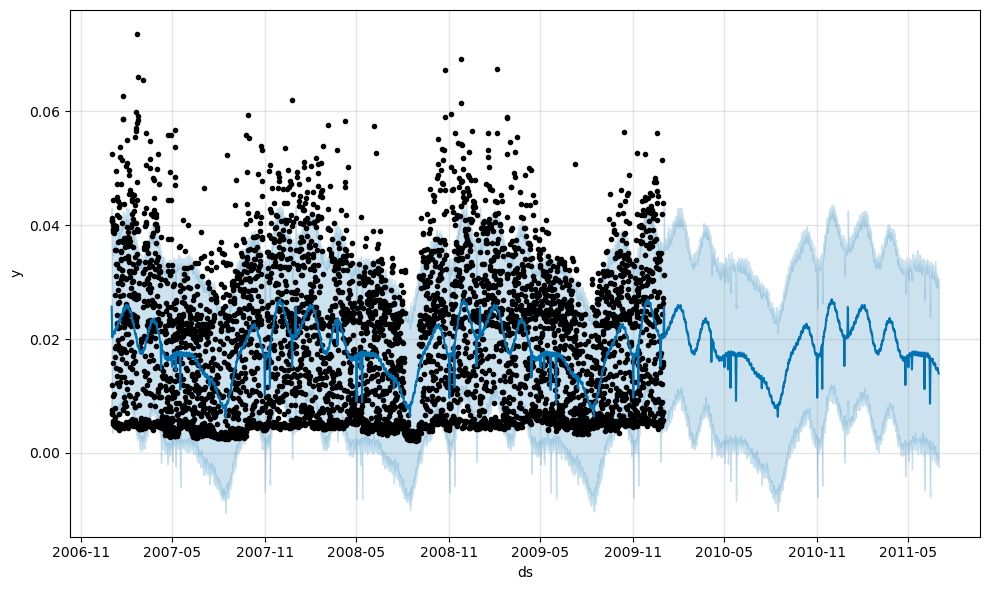

In [86]:
fcst_morning = m_morning.predict(future_morning_final)
fig_morning = m_morning.plot(fcst_morning)

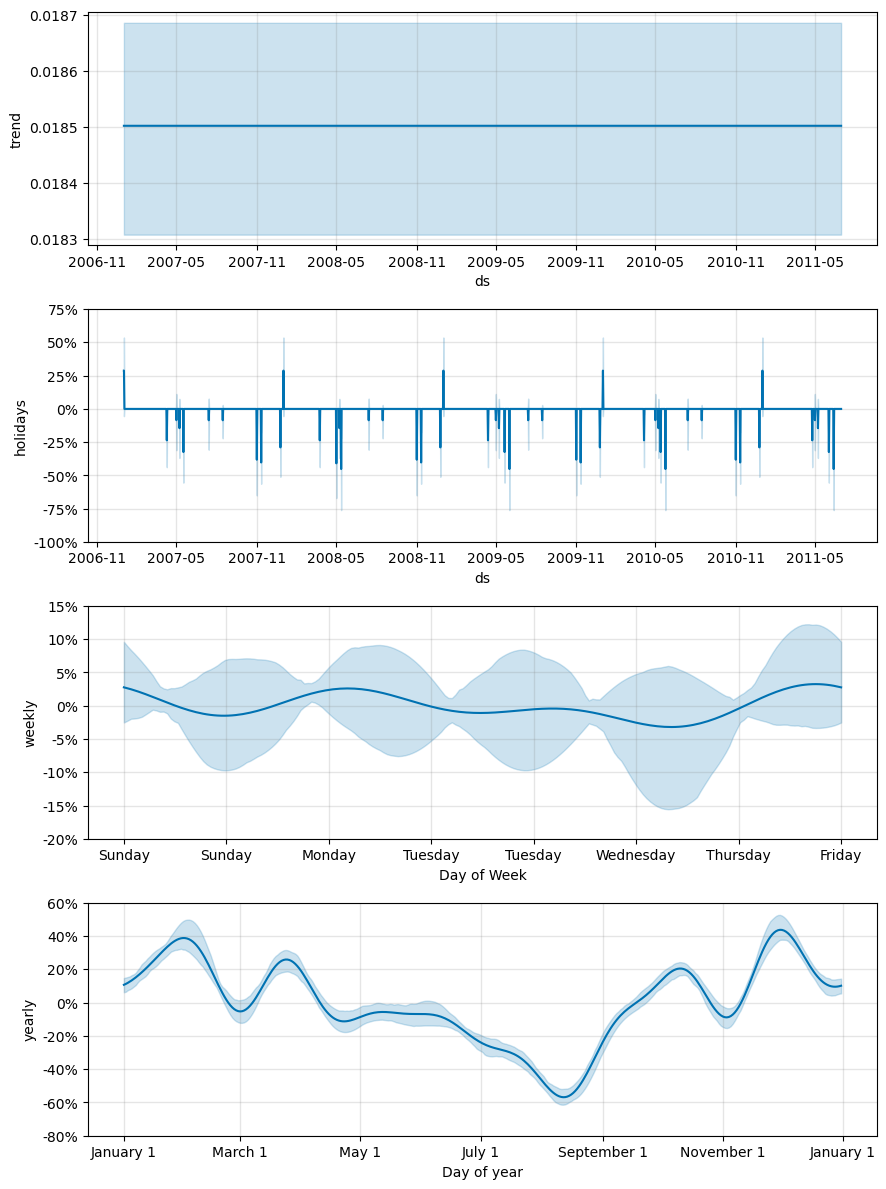

In [87]:
fig_morning_2 = m_morning.plot_components(fcst_morning)

In [88]:
fcst_morning[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
8205 2011-06-30 05:00:00  0.01       -0.00        0.03
8206 2011-06-30 06:00:00  0.01       -0.00        0.03
8207 2011-06-30 07:00:00  0.01       -0.00        0.03
8208 2011-06-30 08:00:00  0.01       -0.00        0.03
8209 2011-06-30 09:00:00  0.01       -0.00        0.03

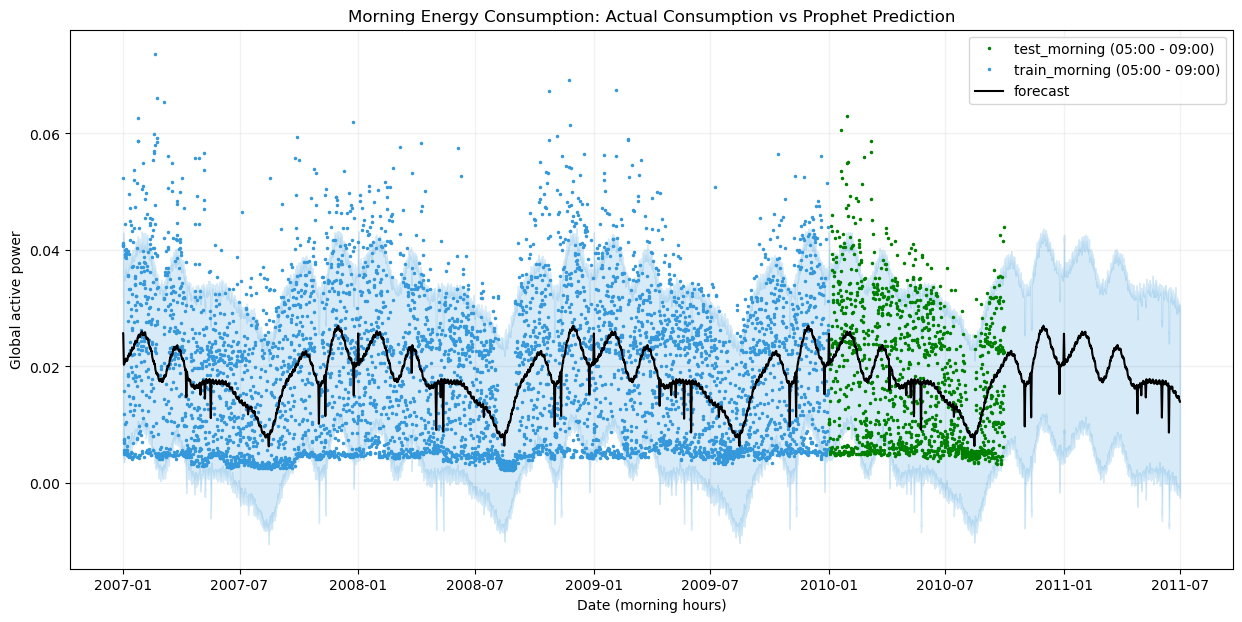

In [106]:
fig_morning_3 = plt.gcf()
fig_morning_3.set_size_inches(15, 7)
plt.plot(test_morning.ds, test_morning.y, '.', markersize=3, color='green', label = "test_morning (05:00 - 09:00)")
plt.plot(train_morning.ds, train_morning.y, '.', markersize=3, color='#3498db', label = "train_morning (05:00 - 09:00)")
plt.plot(fcst_morning.ds, fcst_morning.yhat, color='black', label = "forecast")
plt.fill_between(fcst_morning.ds, fcst_morning.yhat_lower, fcst_morning.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Morning Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (morning hours)')
plt.legend()
plt.show()

## (General) Evening: 17:00 - 22:00

In [25]:
df_evening = df_H[df_H['ds'].dt.hour > 16][df_H['ds'].dt.hour < 23]
df_evening

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1282836237.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_evening = df_H[df_H['ds'].dt.hour > 16][df_H['ds'].dt.hour < 23]


ds    y
0     2006-12-16 17:00:00 0.07
1     2006-12-16 18:00:00 0.06
2     2006-12-16 19:00:00 0.06
3     2006-12-16 20:00:00 0.05
4     2006-12-16 21:00:00 0.05
...                   ...  ...
34584 2010-11-26 17:00:00 0.03
34585 2010-11-26 18:00:00 0.03
34586 2010-11-26 19:00:00 0.03
34587 2010-11-26 20:00:00 0.02
34588 2010-11-26 21:00:00 0.02

[8651 rows x 2 columns]

In [26]:
train_evening=df_evening[(df_evening['ds'] >= '2007-01-01') & (df_evening['ds'] < '2010-01-01 00:00:00')]
test_evening=df_evening[(df_evening['ds'] >= '2010-01-01 00:00:00') & (df_evening['ds'] < '2010-10-01 00:00:00')]

In [27]:
train_evening.shape

(6576, 2)

In [28]:
test_evening.shape

(1638, 2)

In [29]:
train_evening

ds    y
384   2007-01-01 17:00:00 0.03
385   2007-01-01 18:00:00 0.02
386   2007-01-01 19:00:00 0.01
387   2007-01-01 20:00:00 0.01
388   2007-01-01 21:00:00 0.01
...                   ...  ...
26665 2009-12-31 18:00:00 0.05
26666 2009-12-31 19:00:00 0.05
26667 2009-12-31 20:00:00 0.05
26668 2009-12-31 21:00:00 0.05
26669 2009-12-31 22:00:00 0.03

[6576 rows x 2 columns]

In [30]:
test_evening

ds    y
26688 2010-01-01 17:00:00 0.02
26689 2010-01-01 18:00:00 0.01
26690 2010-01-01 19:00:00 0.01
26691 2010-01-01 20:00:00 0.01
26692 2010-01-01 21:00:00 0.01
...                   ...  ...
33217 2010-09-30 18:00:00 0.03
33218 2010-09-30 19:00:00 0.01
33219 2010-09-30 20:00:00 0.01
33220 2010-09-30 21:00:00 0.01
33221 2010-09-30 22:00:00 0.01

[1638 rows x 2 columns]

In [114]:
m_evening = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_evening.add_country_holidays(country_name='FRA')
m_evening.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_evening.fit(train_evening)

20:03:12 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
20:03:12 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
20:03:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:03:22 - cmdstanpy - INFO - CmdStan done processing.
20:03:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Excep

In [118]:
future_evening = m_evening.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_evening.tail(6)

ds
19674 2011-06-30 17:00:00
19675 2011-06-30 18:00:00
19676 2011-06-30 19:00:00
19677 2011-06-30 20:00:00
19678 2011-06-30 21:00:00
19679 2011-06-30 22:00:00

In [120]:
future_evening_final = future_evening.copy()
future_evening_final = future_evening_final[future_evening_final['ds'].dt.hour > 16][future_evening_final['ds'].dt.hour < 23]
future_evening_final.tail(18)

C:\Users\pauli\AppData\Local\Temp\ipykernel_11216\252674487.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_evening_final = future_evening_final[future_evening_final['ds'].dt.hour > 16][future_evening_final['ds'].dt.hour < 23]


ds
19626 2011-06-28 17:00:00
19627 2011-06-28 18:00:00
19628 2011-06-28 19:00:00
19629 2011-06-28 20:00:00
19630 2011-06-28 21:00:00
19631 2011-06-28 22:00:00
19650 2011-06-29 17:00:00
19651 2011-06-29 18:00:00
19652 2011-06-29 19:00:00
19653 2011-06-29 20:00:00
19654 2011-06-29 21:00:00
19655 2011-06-29 22:00:00
19674 2011-06-30 17:00:00
19675 2011-06-30 18:00:00
19676 2011-06-30 19:00:00
19677 2011-06-30 20:00:00
19678 2011-06-30 21:00:00
19679 2011-06-30 22:00:00

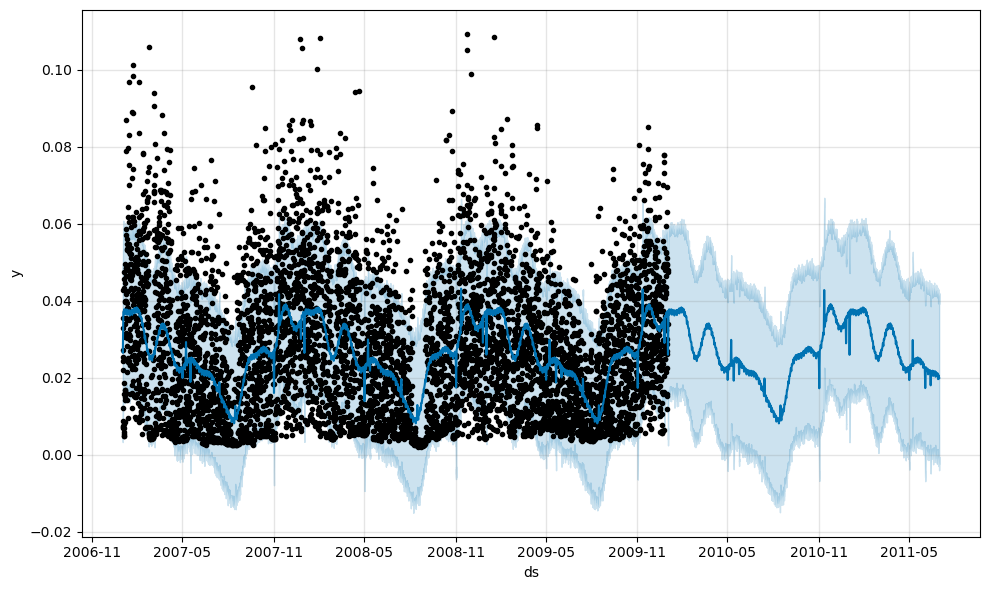

In [121]:
fcst_evening = m_evening.predict(future_evening_final)
fig_evening = m_evening.plot(fcst_evening)

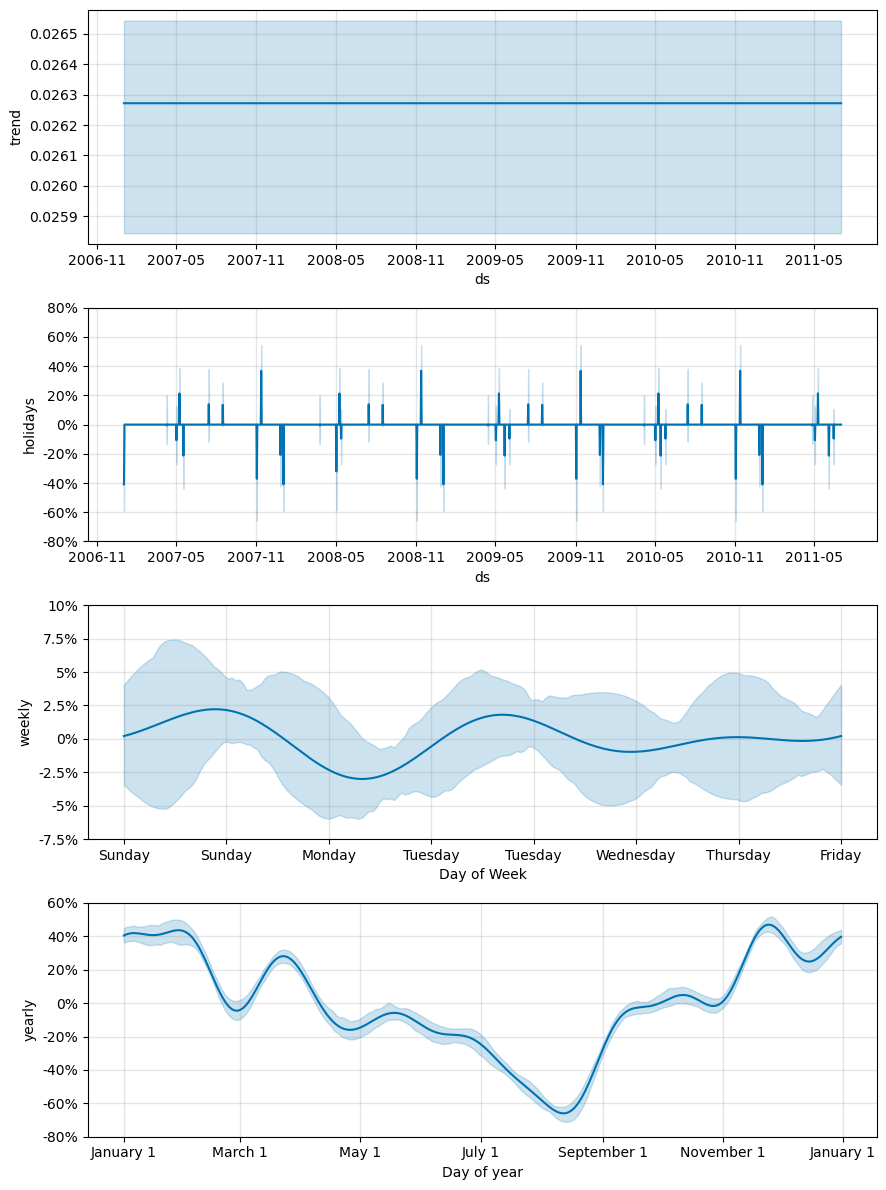

In [122]:
fig_evening_2 = m_evening.plot_components(fcst_evening)

In [123]:
fcst_evening[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
9847 2011-06-30 18:00:00  0.02       -0.00        0.04
9848 2011-06-30 19:00:00  0.02       -0.00        0.04
9849 2011-06-30 20:00:00  0.02       -0.00        0.04
9850 2011-06-30 21:00:00  0.02       -0.00        0.04
9851 2011-06-30 22:00:00  0.02       -0.00        0.04

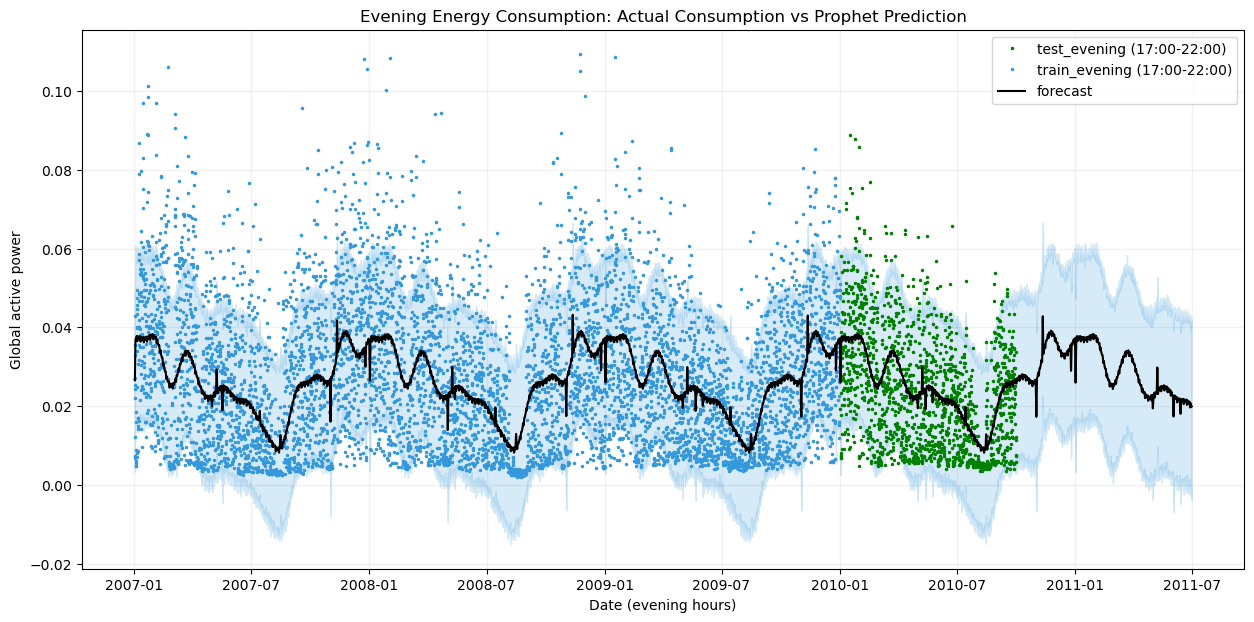

In [124]:
fig_evening_3 = plt.gcf()
fig_evening_3.set_size_inches(15, 7)
plt.plot(test_evening.ds, test_evening.y, '.', markersize=3, color='green', label = "test_evening (17:00-22:00)")
plt.plot(train_evening.ds, train_evening.y, '.', markersize=3, color='#3498db', label = "train_evening (17:00-22:00)")
plt.plot(fcst_evening.ds, fcst_evening.yhat, color='black', label = "forecast")
plt.fill_between(fcst_evening.ds, fcst_evening.yhat_lower, fcst_evening.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Evening Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (evening hours)')
plt.legend()
plt.show()

## Business Day Morning: 05:00 - 09:00

In [99]:
df_H_BDay = df.resample('H', on="ds").mean()
df_H_BDay= df_H_BDay.reset_index(drop=False)
df_H_BDay.head()

ds    y
0 2006-12-16 17:00:00 0.07
1 2006-12-16 18:00:00 0.06
2 2006-12-16 19:00:00 0.06
3 2006-12-16 20:00:00 0.05
4 2006-12-16 21:00:00 0.05

In [106]:
df_BDay = df_BDay[df_H_BDay['ds'].dt.day_of_week >= 0][df_H_BDay['ds'].dt.day_of_week <= 4] 
df_BDay.head(122)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\2252585601.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_BDay = df_BDay[df_H_BDay['ds'].dt.day_of_week >= 0][df_H_BDay['ds'].dt.day_of_week <= 4]


ds    y
31  2006-12-18 00:00:00 0.00
32  2006-12-18 01:00:00 0.01
33  2006-12-18 02:00:00 0.00
34  2006-12-18 03:00:00 0.01
35  2006-12-18 04:00:00 0.02
..                  ...  ...
148 2006-12-22 21:00:00 0.08
149 2006-12-22 22:00:00 0.05
150 2006-12-22 23:00:00 0.04
199 2006-12-25 00:00:00 0.02
200 2006-12-25 01:00:00 0.02

[122 rows x 2 columns]

In [107]:
df_BDay_morning = df_BDay[df_BDay['ds'].dt.hour > 4][df_BDay['ds'].dt.hour < 10]
df_BDay_morning.head(30)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\2475115542.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_BDay_morning = df_BDay[df_BDay['ds'].dt.hour > 4][df_BDay['ds'].dt.hour < 10]


ds    y
36  2006-12-18 05:00:00 0.00
37  2006-12-18 06:00:00 0.01
38  2006-12-18 07:00:00 0.04
39  2006-12-18 08:00:00 0.03
40  2006-12-18 09:00:00 0.03
60  2006-12-19 05:00:00 0.01
61  2006-12-19 06:00:00 0.01
62  2006-12-19 07:00:00 0.03
63  2006-12-19 08:00:00 0.06
64  2006-12-19 09:00:00 0.03
84  2006-12-20 05:00:00 0.00
85  2006-12-20 06:00:00 0.00
86  2006-12-20 07:00:00 0.03
87  2006-12-20 08:00:00 0.05
88  2006-12-20 09:00:00 0.02
108 2006-12-21 05:00:00 0.00
109 2006-12-21 06:00:00 0.00
110 2006-12-21 07:00:00 0.02
111 2006-12-21 08:00:00 0.03
112 2006-12-21 09:00:00 0.04
132 2006-12-22 05:00:00 0.01
133 2006-12-22 06:00:00 0.01
134 2006-12-22 07:00:00 0.03
135 2006-12-22 08:00:00 0.05
136 2006-12-22 09:00:00 0.03
204 2006-12-25 05:00:00 0.01
205 2006-12-25 06:00:00 0.00
206 2006-12-25 07:00:00 0.01
207 2006-12-25 08:00:00 0.04
208 2006-12-25 09:00:00 0.02

In [108]:
train_BDay_morning=df_BDay_morning[(df_BDay_morning['ds'] >= '2007-01-01') & (df_BDay_morning['ds'] < '2010-01-01 00:00:00')]
test_BDay_morning=df_BDay_morning[(df_BDay_morning['ds'] >= '2010-01-01 00:00:00') & (df_BDay_morning['ds'] < '2010-10-01 00:00:00')]

In [109]:
train_BDay_morning.shape

(3920, 2)

In [110]:
test_BDay_morning.shape

(975, 2)

In [118]:
train_BDay_morning.head(30)

ds    y
372 2007-01-01 05:00:00 0.04
373 2007-01-01 06:00:00 0.04
374 2007-01-01 07:00:00 0.04
375 2007-01-01 08:00:00 0.04
376 2007-01-01 09:00:00 0.05
396 2007-01-02 05:00:00 0.01
397 2007-01-02 06:00:00 0.01
398 2007-01-02 07:00:00 0.01
399 2007-01-02 08:00:00 0.01
400 2007-01-02 09:00:00 0.01
420 2007-01-03 05:00:00 0.02
421 2007-01-03 06:00:00 0.01
422 2007-01-03 07:00:00 0.01
423 2007-01-03 08:00:00 0.01
424 2007-01-03 09:00:00 0.01
444 2007-01-04 05:00:00 0.04
445 2007-01-04 06:00:00 0.04
446 2007-01-04 07:00:00 0.04
447 2007-01-04 08:00:00 0.04
448 2007-01-04 09:00:00 0.04
468 2007-01-05 05:00:00 0.04
469 2007-01-05 06:00:00 0.04
470 2007-01-05 07:00:00 0.04
471 2007-01-05 08:00:00 0.04
472 2007-01-05 09:00:00 0.04
540 2007-01-08 05:00:00 0.02
541 2007-01-08 06:00:00 0.01
542 2007-01-08 07:00:00 0.02
543 2007-01-08 08:00:00 0.04
544 2007-01-08 09:00:00 0.03

In [115]:
test_BDay_morning.shape

(975, 2)

In [117]:
test_BDay_morning.head(30)

ds    y
26676 2010-01-01 05:00:00 0.01
26677 2010-01-01 06:00:00 0.01
26678 2010-01-01 07:00:00 0.01
26679 2010-01-01 08:00:00 0.01
26680 2010-01-01 09:00:00 0.01
26748 2010-01-04 05:00:00 0.01
26749 2010-01-04 06:00:00 0.02
26750 2010-01-04 07:00:00 0.04
26751 2010-01-04 08:00:00 0.02
26752 2010-01-04 09:00:00 0.02
26772 2010-01-05 05:00:00 0.01
26773 2010-01-05 06:00:00 0.02
26774 2010-01-05 07:00:00 0.04
26775 2010-01-05 08:00:00 0.05
26776 2010-01-05 09:00:00 0.04
26796 2010-01-06 05:00:00 0.01
26797 2010-01-06 06:00:00 0.03
26798 2010-01-06 07:00:00 0.04
26799 2010-01-06 08:00:00 0.02
26800 2010-01-06 09:00:00 0.02
26820 2010-01-07 05:00:00 0.01
26821 2010-01-07 06:00:00 0.02
26822 2010-01-07 07:00:00 0.03
26823 2010-01-07 08:00:00 0.03
26824 2010-01-07 09:00:00 0.02
26844 2010-01-08 05:00:00 0.01
26845 2010-01-08 06:00:00 0.02
26846 2010-01-08 07:00:00 0.04
26847 2010-01-08 08:00:00 0.03
26848 2010-01-08 09:00:00 0.03

In [119]:
m_BDay_morning = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_BDay_morning.add_country_holidays(country_name='FRA')
m_BDay_morning.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_BDay_morning.fit(train_BDay_morning)

14:39:02 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
14:39:02 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
14:39:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:39:05 - cmdstanpy - INFO - CmdStan done processing.
14:39:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142,

In [122]:
future_BDay_morning = m_BDay_morning.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_BDay_morning.tail()

ds
17019 2011-06-30 05:00:00
17020 2011-06-30 06:00:00
17021 2011-06-30 07:00:00
17022 2011-06-30 08:00:00
17023 2011-06-30 09:00:00

In [124]:
future_BDay_morning_final = future_BDay_morning.copy()
future_BDay_morning_final = future_BDay_morning_final[future_BDay_morning_final['ds'].dt.day_of_week >= 0][future_BDay_morning_final['ds'].dt.day_of_week <= 4] [future_BDay_morning_final['ds'].dt.hour > 4][future_BDay_morning_final['ds'].dt.hour < 10]
future_BDay_morning_final.tail(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\3921969703.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_BDay_morning_final = future_BDay_morning_final[future_BDay_morning_final['ds'].dt.day_of_week >= 0][future_BDay_morning_final['ds'].dt.day_of_week <= 4] [future_BDay_morning_final['ds'].dt.hour > 4][future_BDay_morning_final['ds'].dt.hour < 10]


ds
16707 2011-06-17 05:00:00
16708 2011-06-17 06:00:00
16709 2011-06-17 07:00:00
16710 2011-06-17 08:00:00
16711 2011-06-17 09:00:00
16779 2011-06-20 05:00:00
16780 2011-06-20 06:00:00
16781 2011-06-20 07:00:00
16782 2011-06-20 08:00:00
16783 2011-06-20 09:00:00
16803 2011-06-21 05:00:00
16804 2011-06-21 06:00:00
16805 2011-06-21 07:00:00
16806 2011-06-21 08:00:00
16807 2011-06-21 09:00:00
16827 2011-06-22 05:00:00
16828 2011-06-22 06:00:00
16829 2011-06-22 07:00:00
16830 2011-06-22 08:00:00
16831 2011-06-22 09:00:00
16851 2011-06-23 05:00:00
16852 2011-06-23 06:00:00
16853 2011-06-23 07:00:00
16854 2011-06-23 08:00:00
16855 2011-06-23 09:00:00
16875 2011-06-24 05:00:00
16876 2011-06-24 06:00:00
16877 2011-06-24 07:00:00
16878 2011-06-24 08:00:00
16879 2011-06-24 09:00:00
16947 2011-06-27 05:00:00
16948 2011-06-27 06:00:00
16949 2011-06-27 07:00:00
16950 2011-06-27 08:00:00
16951 2011-06-27 09:00:00
16971 2011-06-28 05:00:00
16972 2011-06-28 06:00:00
16973 2011-06-28 07:00:00
16974 2011-06-28 08:00:00
16975 2011-06-28 09:00:00
16995 2011-06-29 05:00:00
16996 2011-06-29 06:00:00
16997 2011-06-29 07:00:00
16998 2011-06-29 08:00:00
16999 2011-06-29 09:00:00
17019 2011-06-30 05:00:00
17020 2011-06-30 06:00:00
17021 2011-06-30 07:00:00
17022 2011-06-30 08:00:00
17023 2011-06-30 09:00:00

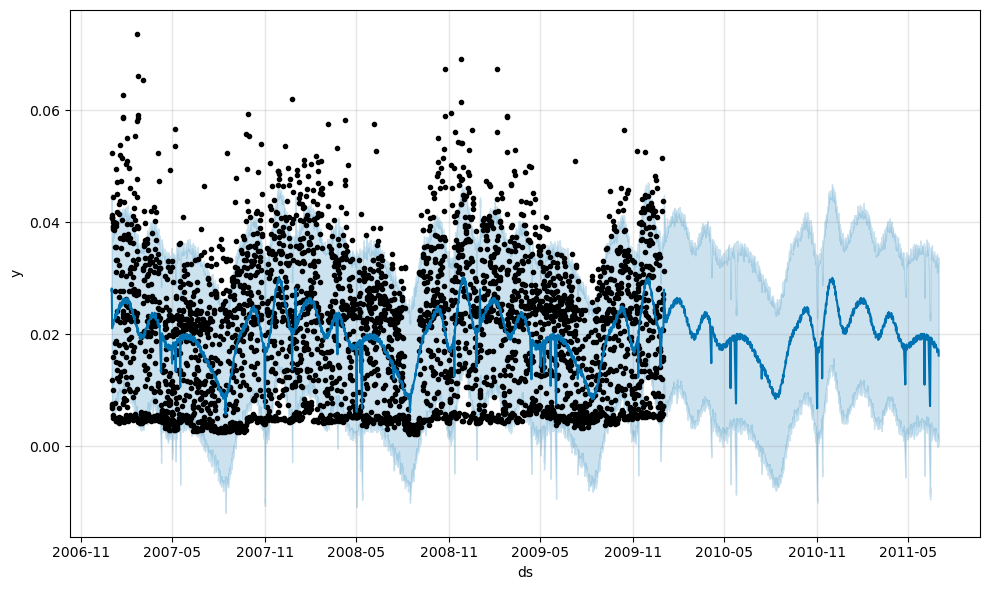

In [125]:
fcst_BDay_morning = m_BDay_morning.predict(future_BDay_morning_final)
fig_BDay_morning = m_BDay_morning.plot(fcst_BDay_morning)

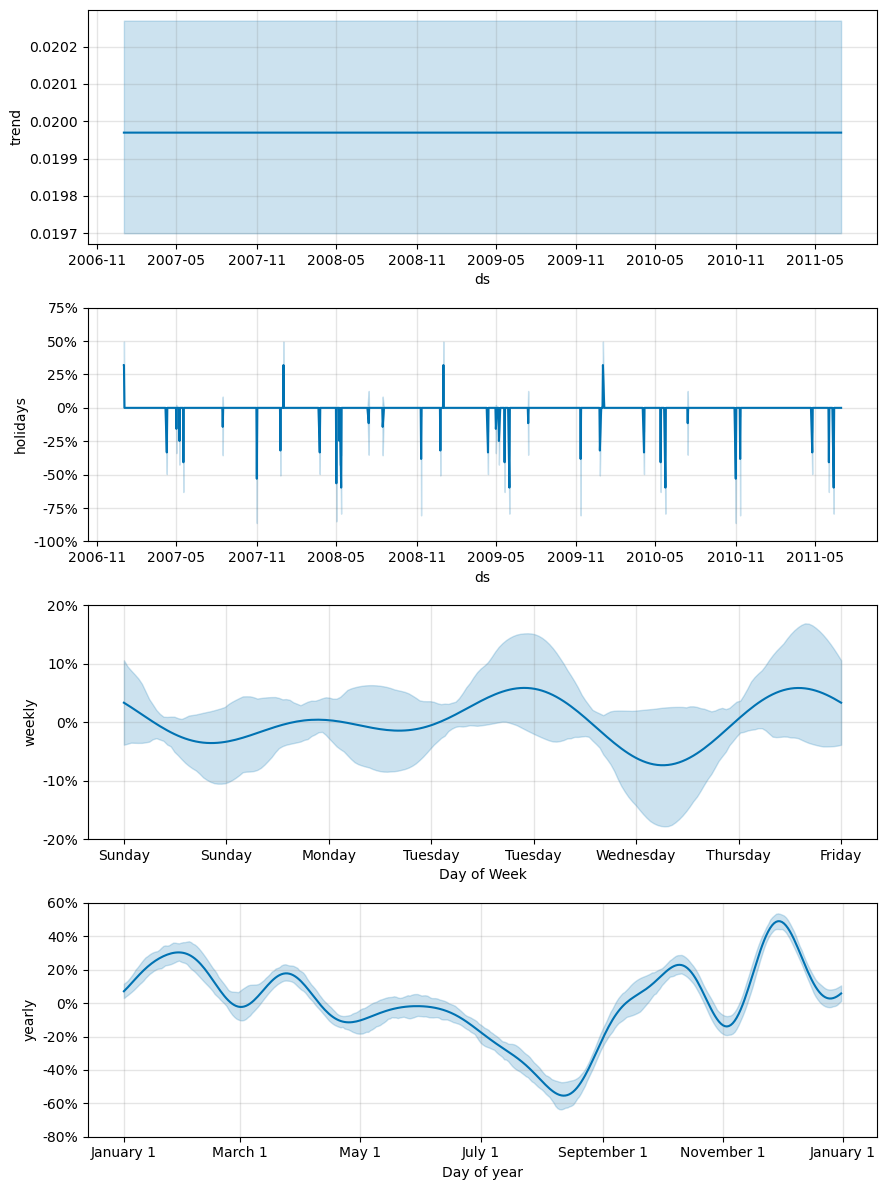

In [126]:
fig_BDay_morning_2 = m_BDay_morning.plot_components(fcst_BDay_morning)

In [127]:
fcst_BDay_morning[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
5865 2011-06-30 05:00:00  0.02        0.00        0.03
5866 2011-06-30 06:00:00  0.02        0.00        0.03
5867 2011-06-30 07:00:00  0.02        0.00        0.03
5868 2011-06-30 08:00:00  0.02        0.00        0.03
5869 2011-06-30 09:00:00  0.02        0.00        0.03

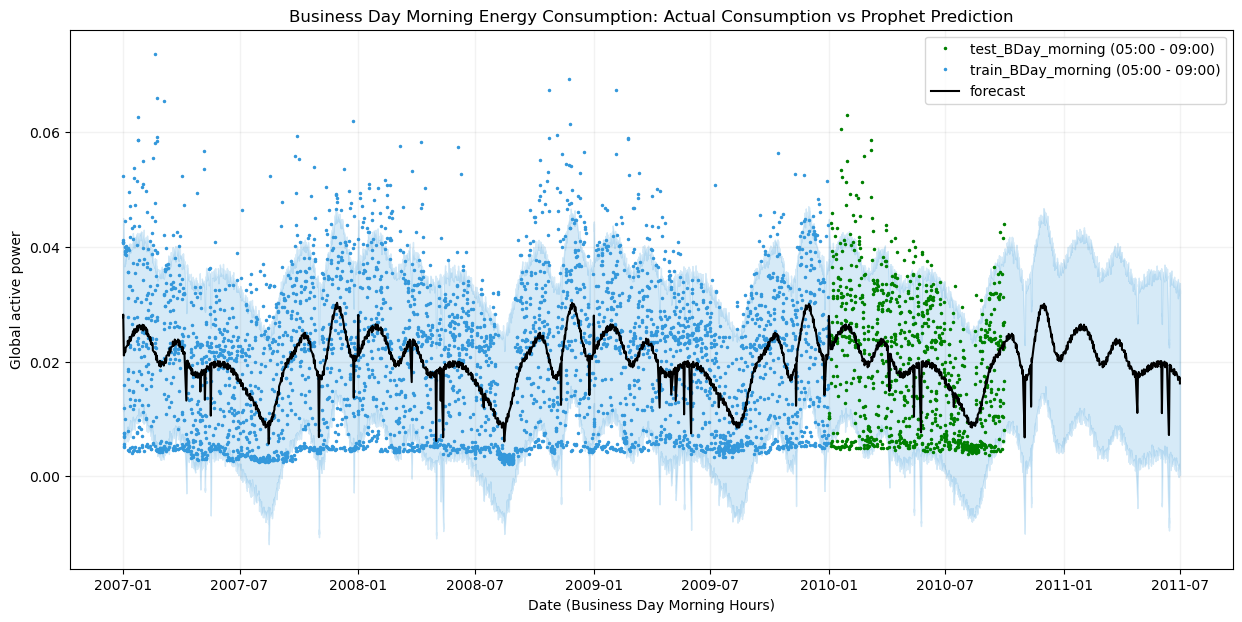

In [128]:
fig_BDay_morning_3 = plt.gcf()
fig_BDay_morning_3.set_size_inches(15, 7)
plt.plot(test_BDay_morning.ds, test_BDay_morning.y, '.', markersize=3, color='green', label = "test_BDay_morning (05:00 - 09:00)")
plt.plot(train_BDay_morning.ds, train_BDay_morning.y, '.', markersize=3, color='#3498db', label = "train_BDay_morning (05:00 - 09:00)")
plt.plot(fcst_BDay_morning.ds, fcst_BDay_morning.yhat, color='black', label = "forecast")
plt.fill_between(fcst_BDay_morning.ds, fcst_BDay_morning.yhat_lower, fcst_BDay_morning.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Business Day Morning Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (Business Day Morning Hours)')
plt.legend()
plt.show()

In [217]:
df_cv_BDay_morning = cross_validation(m_BDay_morning,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_BDay_morning_p = performance_metrics(df_cv_BDay_morning)
df_cv_BDay_morning_p.head()

horizon  mse  rmse  mae  mape  mdape  smape  coverage
0  9 days 20:00:00 0.00  0.01 0.01  0.89   0.41   0.58      0.83
1  9 days 21:00:00 0.00  0.01 0.01  0.90   0.42   0.58      0.83
2  9 days 22:00:00 0.00  0.01 0.01  0.91   0.43   0.58      0.82
3  9 days 23:00:00 0.00  0.01 0.01  0.91   0.43   0.58      0.82
4 10 days 00:00:00 0.00  0.01 0.01  0.92   0.43   0.59      0.82

## Weekend Morning: 05:00 - 09:00

In [129]:
df_H_W = df.resample('H', on="ds").mean()
df_H_W = df_H_W.reset_index(drop=False)
df_H_W.head()

ds    y
0 2006-12-16 17:00:00 0.07
1 2006-12-16 18:00:00 0.06
2 2006-12-16 19:00:00 0.06
3 2006-12-16 20:00:00 0.05
4 2006-12-16 21:00:00 0.05

In [132]:
df_W = df_H_W[df_H_W['ds'].dt.day_of_week >= 5][df_H_W['ds'].dt.day_of_week <= 6] 
df_W.head(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1667604247.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_W = df_H_W[df_H_W['ds'].dt.day_of_week >= 5][df_H_W['ds'].dt.day_of_week <= 6]


ds    y
0   2006-12-16 17:00:00 0.07
1   2006-12-16 18:00:00 0.06
2   2006-12-16 19:00:00 0.06
3   2006-12-16 20:00:00 0.05
4   2006-12-16 21:00:00 0.05
5   2006-12-16 22:00:00 0.04
6   2006-12-16 23:00:00 0.03
7   2006-12-17 00:00:00 0.03
8   2006-12-17 01:00:00 0.06
9   2006-12-17 02:00:00 0.03
10  2006-12-17 03:00:00 0.03
11  2006-12-17 04:00:00 0.04
12  2006-12-17 05:00:00 0.03
13  2006-12-17 06:00:00 0.02
14  2006-12-17 07:00:00 0.03
15  2006-12-17 08:00:00 0.03
16  2006-12-17 09:00:00 0.04
17  2006-12-17 10:00:00 0.06
18  2006-12-17 11:00:00 0.04
19  2006-12-17 12:00:00 0.03
20  2006-12-17 13:00:00 0.03
21  2006-12-17 14:00:00 0.03
22  2006-12-17 15:00:00 0.05
23  2006-12-17 16:00:00 0.06
24  2006-12-17 17:00:00 0.06
25  2006-12-17 18:00:00 0.06
26  2006-12-17 19:00:00 0.05
27  2006-12-17 20:00:00 0.06
28  2006-12-17 21:00:00 0.05
29  2006-12-17 22:00:00 0.03
30  2006-12-17 23:00:00 0.01
151 2006-12-23 00:00:00 0.03
152 2006-12-23 01:00:00 0.03
153 2006-12-23 02:00:00 0.03
154 2006-12-23 03:00:00 0.03
155 2006-12-23 04:00:00 0.03
156 2006-12-23 05:00:00 0.04
157 2006-12-23 06:00:00 0.03
158 2006-12-23 07:00:00 0.07
159 2006-12-23 08:00:00 0.07
160 2006-12-23 09:00:00 0.05
161 2006-12-23 10:00:00 0.05
162 2006-12-23 11:00:00 0.05
163 2006-12-23 12:00:00 0.05
164 2006-12-23 13:00:00 0.06
165 2006-12-23 14:00:00 0.06
166 2006-12-23 15:00:00 0.07
167 2006-12-23 16:00:00 0.07
168 2006-12-23 17:00:00 0.09
169 2006-12-23 18:00:00 0.06

In [133]:
df_W_morning = df_W[df_W['ds'].dt.hour > 4][df_W['ds'].dt.hour < 10]
df_W_morning.head(30)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\3917962510.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_W_morning = df_W[df_W['ds'].dt.hour > 4][df_W['ds'].dt.hour < 10]


ds    y
12  2006-12-17 05:00:00 0.03
13  2006-12-17 06:00:00 0.02
14  2006-12-17 07:00:00 0.03
15  2006-12-17 08:00:00 0.03
16  2006-12-17 09:00:00 0.04
156 2006-12-23 05:00:00 0.04
157 2006-12-23 06:00:00 0.03
158 2006-12-23 07:00:00 0.07
159 2006-12-23 08:00:00 0.07
160 2006-12-23 09:00:00 0.05
180 2006-12-24 05:00:00 0.03
181 2006-12-24 06:00:00 0.03
182 2006-12-24 07:00:00 0.02
183 2006-12-24 08:00:00 0.02
184 2006-12-24 09:00:00 0.05
324 2006-12-30 05:00:00 0.00
325 2006-12-30 06:00:00 0.02
326 2006-12-30 07:00:00 0.00
327 2006-12-30 08:00:00 0.03
328 2006-12-30 09:00:00 0.05
348 2006-12-31 05:00:00 0.02
349 2006-12-31 06:00:00 0.04
350 2006-12-31 07:00:00 0.06
351 2006-12-31 08:00:00 0.07
352 2006-12-31 09:00:00 0.05
492 2007-01-06 05:00:00 0.01
493 2007-01-06 06:00:00 0.00
494 2007-01-06 07:00:00 0.01
495 2007-01-06 08:00:00 0.00
496 2007-01-06 09:00:00 0.01

In [134]:
train_W_morning=df_W_morning[(df_W_morning['ds'] >= '2007-01-01') & (df_W_morning['ds'] < '2010-01-01 00:00:00')]
test_W_morning=df_W_morning[(df_W_morning['ds'] >= '2010-01-01 00:00:00') & (df_W_morning['ds'] < '2010-10-01 00:00:00')]

In [135]:
train_W_morning.shape

(1560, 2)

In [136]:
test_W_morning.shape

(390, 2)

In [137]:
train_W_morning

ds    y
492   2007-01-06 05:00:00 0.01
493   2007-01-06 06:00:00 0.00
494   2007-01-06 07:00:00 0.01
495   2007-01-06 08:00:00 0.00
496   2007-01-06 09:00:00 0.01
...                   ...  ...
26556 2009-12-27 05:00:00 0.00
26557 2009-12-27 06:00:00 0.01
26558 2009-12-27 07:00:00 0.01
26559 2009-12-27 08:00:00 0.02
26560 2009-12-27 09:00:00 0.02

[1560 rows x 2 columns]

In [138]:
test_W_morning.shape

(390, 2)

In [139]:
test_W_morning

ds    y
26700 2010-01-02 05:00:00 0.01
26701 2010-01-02 06:00:00 0.00
26702 2010-01-02 07:00:00 0.01
26703 2010-01-02 08:00:00 0.01
26704 2010-01-02 09:00:00 0.02
...                   ...  ...
33108 2010-09-26 05:00:00 0.00
33109 2010-09-26 06:00:00 0.00
33110 2010-09-26 07:00:00 0.01
33111 2010-09-26 08:00:00 0.02
33112 2010-09-26 09:00:00 0.01

[390 rows x 2 columns]

In [140]:
m_W_morning = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_W_morning.add_country_holidays(country_name='FRA')
m_W_morning.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_W_morning.fit(train_W_morning)

15:20:48 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:20:48 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:20:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:20:50 - cmdstanpy - INFO - CmdStan done processing.
15:20:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, colu

In [141]:
future_W_morning = m_W_morning.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_W_morning.tail()

ds
14659 2011-06-26 05:00:00
14660 2011-06-26 06:00:00
14661 2011-06-26 07:00:00
14662 2011-06-26 08:00:00
14663 2011-06-26 09:00:00

In [142]:
future_W_morning_final = future_W_morning.copy()
future_W_morning_final = future_W_morning_final[future_W_morning_final['ds'].dt.day_of_week >= 5][future_W_morning_final['ds'].dt.day_of_week <= 6] [future_W_morning_final['ds'].dt.hour > 4][future_W_morning_final['ds'].dt.hour < 10]
future_W_morning_final.tail(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1503477204.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_W_morning_final = future_W_morning_final[future_W_morning_final['ds'].dt.day_of_week >= 5][future_W_morning_final['ds'].dt.day_of_week <= 6] [future_W_morning_final['ds'].dt.hour > 4][future_W_morning_final['ds'].dt.hour < 10]


ds
13963 2011-05-28 05:00:00
13964 2011-05-28 06:00:00
13965 2011-05-28 07:00:00
13966 2011-05-28 08:00:00
13967 2011-05-28 09:00:00
13987 2011-05-29 05:00:00
13988 2011-05-29 06:00:00
13989 2011-05-29 07:00:00
13990 2011-05-29 08:00:00
13991 2011-05-29 09:00:00
14131 2011-06-04 05:00:00
14132 2011-06-04 06:00:00
14133 2011-06-04 07:00:00
14134 2011-06-04 08:00:00
14135 2011-06-04 09:00:00
14155 2011-06-05 05:00:00
14156 2011-06-05 06:00:00
14157 2011-06-05 07:00:00
14158 2011-06-05 08:00:00
14159 2011-06-05 09:00:00
14299 2011-06-11 05:00:00
14300 2011-06-11 06:00:00
14301 2011-06-11 07:00:00
14302 2011-06-11 08:00:00
14303 2011-06-11 09:00:00
14323 2011-06-12 05:00:00
14324 2011-06-12 06:00:00
14325 2011-06-12 07:00:00
14326 2011-06-12 08:00:00
14327 2011-06-12 09:00:00
14467 2011-06-18 05:00:00
14468 2011-06-18 06:00:00
14469 2011-06-18 07:00:00
14470 2011-06-18 08:00:00
14471 2011-06-18 09:00:00
14491 2011-06-19 05:00:00
14492 2011-06-19 06:00:00
14493 2011-06-19 07:00:00
14494 2011-06-19 08:00:00
14495 2011-06-19 09:00:00
14635 2011-06-25 05:00:00
14636 2011-06-25 06:00:00
14637 2011-06-25 07:00:00
14638 2011-06-25 08:00:00
14639 2011-06-25 09:00:00
14659 2011-06-26 05:00:00
14660 2011-06-26 06:00:00
14661 2011-06-26 07:00:00
14662 2011-06-26 08:00:00
14663 2011-06-26 09:00:00

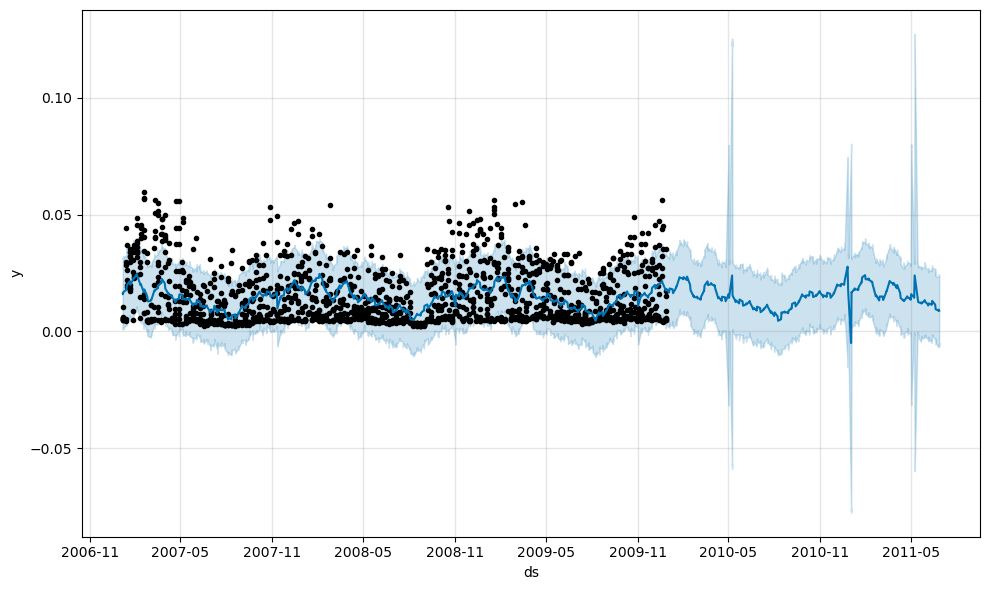

In [143]:
fcst_W_morning = m_W_morning.predict(future_W_morning_final)
fig_W_morning = m_W_morning.plot(fcst_W_morning)

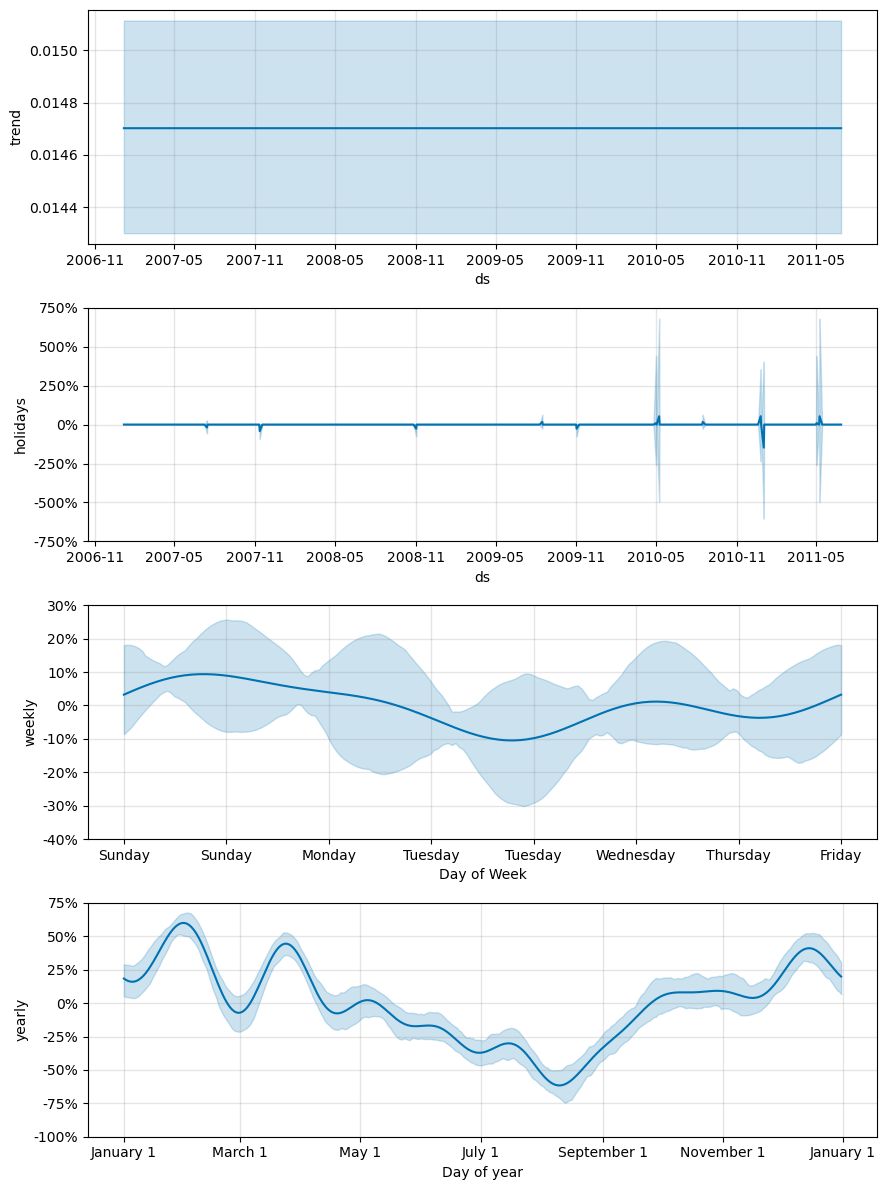

In [144]:
fig_W_morning_2 = m_W_morning.plot_components(fcst_W_morning)

In [145]:
fcst_W_morning[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
2335 2011-06-26 05:00:00  0.01       -0.01        0.02
2336 2011-06-26 06:00:00  0.01       -0.01        0.02
2337 2011-06-26 07:00:00  0.01       -0.00        0.02
2338 2011-06-26 08:00:00  0.01       -0.00        0.02
2339 2011-06-26 09:00:00  0.01       -0.01        0.02

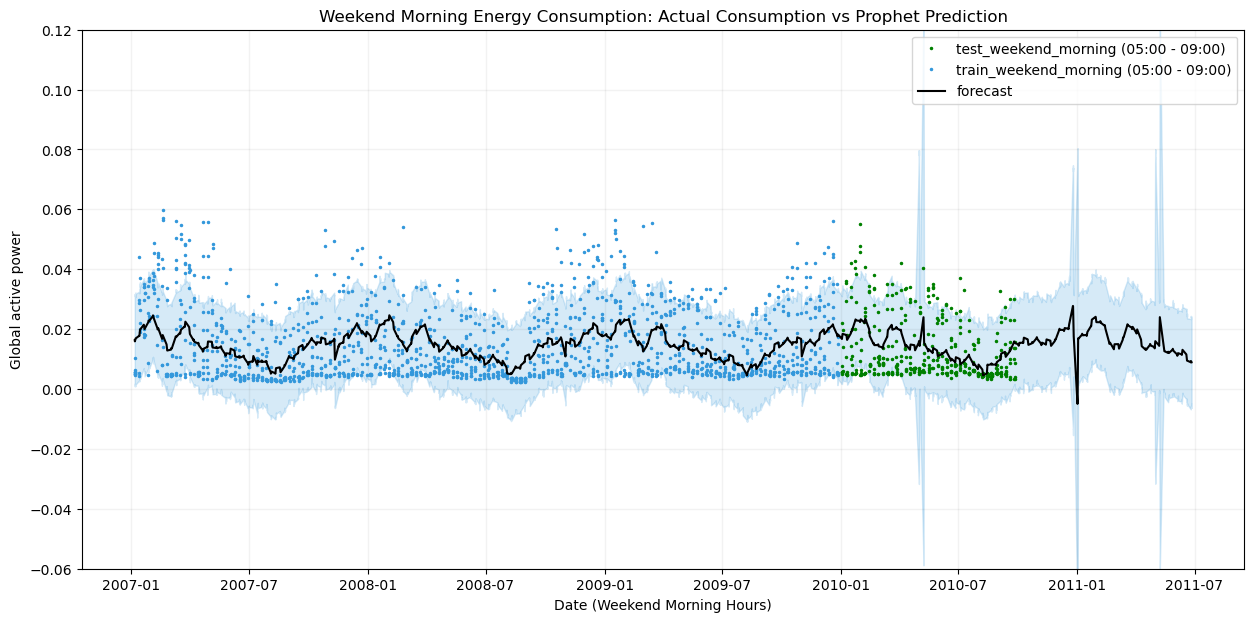

In [152]:
fig_W_morning_3 = plt.gcf()
fig_W_morning_3.set_size_inches(15, 7)
plt.plot(test_W_morning.ds, test_W_morning.y, '.', markersize=3, color='green', label = "test_weekend_morning (05:00 - 09:00)")
plt.plot(train_W_morning.ds, train_W_morning.y, '.', markersize=3, color='#3498db', label = "train_weekend_morning (05:00 - 09:00)")
plt.plot(fcst_W_morning.ds, fcst_W_morning.yhat, color='black', label = "forecast")
plt.fill_between(fcst_W_morning.ds, fcst_W_morning.yhat_lower, fcst_W_morning.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Weekend Morning Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (Weekend Morning Hours)')
plt.ylim(-0.06,0.12)
plt.legend()
plt.show()

In [216]:
df_cv_W_morning = cross_validation(m_W_morning,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_W_morning_p = performance_metrics(df_cv_W_morning)
df_cv_W_morning_p.head()

horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 9 days 00:00:00 0.00  0.01 0.01  0.84   0.55   0.61      0.83
1 9 days 20:00:00 0.00  0.01 0.01  0.84   0.55   0.61      0.84
2 9 days 21:00:00 0.00  0.01 0.01  0.83   0.56   0.61      0.85
3 9 days 22:00:00 0.00  0.01 0.01  0.82   0.56   0.61      0.84
4 9 days 23:00:00 0.00  0.01 0.01  0.81   0.56   0.61      0.84

## Business Day Evening: 17:00 - 22:00

In [153]:
df_H_BDay = df.resample('H', on="ds").mean()
df_H_BDay= df_H_BDay.reset_index(drop=False)
df_H_BDay.head()

ds    y
0 2006-12-16 17:00:00 0.07
1 2006-12-16 18:00:00 0.06
2 2006-12-16 19:00:00 0.06
3 2006-12-16 20:00:00 0.05
4 2006-12-16 21:00:00 0.05

In [154]:
df_BDay = df_H_BDay[df_H_BDay['ds'].dt.day_of_week >= 0][df_H_BDay['ds'].dt.day_of_week <= 4] 
df_BDay.head(122)

ds    y
31  2006-12-18 00:00:00 0.00
32  2006-12-18 01:00:00 0.01
33  2006-12-18 02:00:00 0.00
34  2006-12-18 03:00:00 0.01
35  2006-12-18 04:00:00 0.02
..                  ...  ...
148 2006-12-22 21:00:00 0.08
149 2006-12-22 22:00:00 0.05
150 2006-12-22 23:00:00 0.04
199 2006-12-25 00:00:00 0.02
200 2006-12-25 01:00:00 0.02

[122 rows x 2 columns]

In [155]:
df_BDay_evening = df_BDay[df_BDay['ds'].dt.hour > 16][df_BDay['ds'].dt.hour < 23]
df_BDay_evening

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\2564674509.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_BDay_evening = df_BDay[df_BDay['ds'].dt.hour > 16][df_BDay['ds'].dt.hour < 23]


ds    y
48    2006-12-18 17:00:00 0.04
49    2006-12-18 18:00:00 0.04
50    2006-12-18 19:00:00 0.04
51    2006-12-18 20:00:00 0.05
52    2006-12-18 21:00:00 0.04
...                   ...  ...
34584 2010-11-26 17:00:00 0.03
34585 2010-11-26 18:00:00 0.03
34586 2010-11-26 19:00:00 0.03
34587 2010-11-26 20:00:00 0.02
34588 2010-11-26 21:00:00 0.02

[6179 rows x 2 columns]

In [156]:
train_BDay_evening=df_BDay_evening[(df_BDay_evening['ds'] >= '2007-01-01') & (df_BDay_evening['ds'] < '2010-01-01 00:00:00')]
test_BDay_evening=df_BDay_evening[(df_BDay_evening['ds'] >= '2010-01-01 00:00:00') & (df_BDay_evening['ds'] < '2010-10-01 00:00:00')]

In [157]:
train_BDay_evening.shape

(4704, 2)

In [158]:
test_BDay_evening.shape

(1170, 2)

In [159]:
train_BDay_evening

ds    y
384   2007-01-01 17:00:00 0.03
385   2007-01-01 18:00:00 0.02
386   2007-01-01 19:00:00 0.01
387   2007-01-01 20:00:00 0.01
388   2007-01-01 21:00:00 0.01
...                   ...  ...
26665 2009-12-31 18:00:00 0.05
26666 2009-12-31 19:00:00 0.05
26667 2009-12-31 20:00:00 0.05
26668 2009-12-31 21:00:00 0.05
26669 2009-12-31 22:00:00 0.03

[4704 rows x 2 columns]

In [160]:
test_BDay_evening

ds    y
26688 2010-01-01 17:00:00 0.02
26689 2010-01-01 18:00:00 0.01
26690 2010-01-01 19:00:00 0.01
26691 2010-01-01 20:00:00 0.01
26692 2010-01-01 21:00:00 0.01
...                   ...  ...
33217 2010-09-30 18:00:00 0.03
33218 2010-09-30 19:00:00 0.01
33219 2010-09-30 20:00:00 0.01
33220 2010-09-30 21:00:00 0.01
33221 2010-09-30 22:00:00 0.01

[1170 rows x 2 columns]

In [161]:
m_BDay_evening = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_BDay_evening.add_country_holidays(country_name='FRA')
m_BDay_evening.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_BDay_evening.fit(train_BDay_evening)

15:40:01 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:40:01 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:40:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:40:03 - cmdstanpy - INFO - CmdStan done processing.
15:40:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, col

In [162]:
future_BDay_evening = m_BDay_evening.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_BDay_evening.tail(6)

ds
17802 2011-06-30 17:00:00
17803 2011-06-30 18:00:00
17804 2011-06-30 19:00:00
17805 2011-06-30 20:00:00
17806 2011-06-30 21:00:00
17807 2011-06-30 22:00:00

In [164]:
future_BDay_evening_final = future_BDay_evening.copy()
future_BDay_evening_final = future_BDay_evening_final[future_BDay_evening_final['ds'].dt.day_of_week >= 0][future_BDay_evening_final['ds'].dt.day_of_week <= 4] [future_BDay_evening_final['ds'].dt.hour > 16][future_BDay_evening_final['ds'].dt.hour < 23]
future_BDay_evening_final.tail(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1506556678.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_BDay_evening_final = future_BDay_evening_final[future_BDay_evening_final['ds'].dt.day_of_week >= 0][future_BDay_evening_final['ds'].dt.day_of_week <= 4] [future_BDay_evening_final['ds'].dt.hour > 16][future_BDay_evening_final['ds'].dt.hour < 23]


ds
17566 2011-06-20 21:00:00
17567 2011-06-20 22:00:00
17586 2011-06-21 17:00:00
17587 2011-06-21 18:00:00
17588 2011-06-21 19:00:00
17589 2011-06-21 20:00:00
17590 2011-06-21 21:00:00
17591 2011-06-21 22:00:00
17610 2011-06-22 17:00:00
17611 2011-06-22 18:00:00
17612 2011-06-22 19:00:00
17613 2011-06-22 20:00:00
17614 2011-06-22 21:00:00
17615 2011-06-22 22:00:00
17634 2011-06-23 17:00:00
17635 2011-06-23 18:00:00
17636 2011-06-23 19:00:00
17637 2011-06-23 20:00:00
17638 2011-06-23 21:00:00
17639 2011-06-23 22:00:00
17658 2011-06-24 17:00:00
17659 2011-06-24 18:00:00
17660 2011-06-24 19:00:00
17661 2011-06-24 20:00:00
17662 2011-06-24 21:00:00
17663 2011-06-24 22:00:00
17730 2011-06-27 17:00:00
17731 2011-06-27 18:00:00
17732 2011-06-27 19:00:00
17733 2011-06-27 20:00:00
17734 2011-06-27 21:00:00
17735 2011-06-27 22:00:00
17754 2011-06-28 17:00:00
17755 2011-06-28 18:00:00
17756 2011-06-28 19:00:00
17757 2011-06-28 20:00:00
17758 2011-06-28 21:00:00
17759 2011-06-28 22:00:00
17778 2011-06-29 17:00:00
17779 2011-06-29 18:00:00
17780 2011-06-29 19:00:00
17781 2011-06-29 20:00:00
17782 2011-06-29 21:00:00
17783 2011-06-29 22:00:00
17802 2011-06-30 17:00:00
17803 2011-06-30 18:00:00
17804 2011-06-30 19:00:00
17805 2011-06-30 20:00:00
17806 2011-06-30 21:00:00
17807 2011-06-30 22:00:00

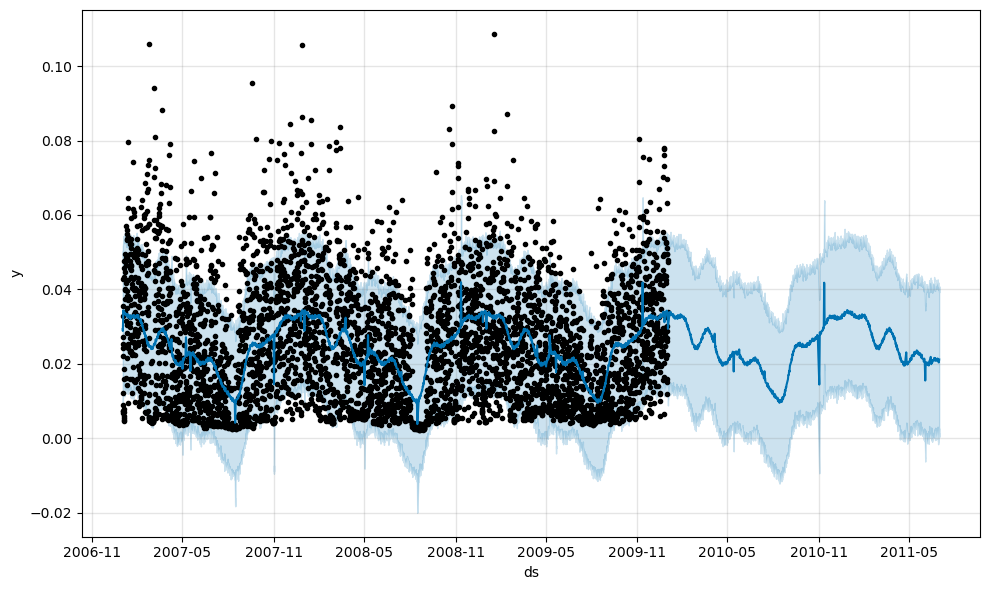

In [165]:
fcst_BDay_evening = m_BDay_evening.predict(future_BDay_evening_final)
fig_BDay_evening = m_BDay_evening.plot(fcst_BDay_evening)

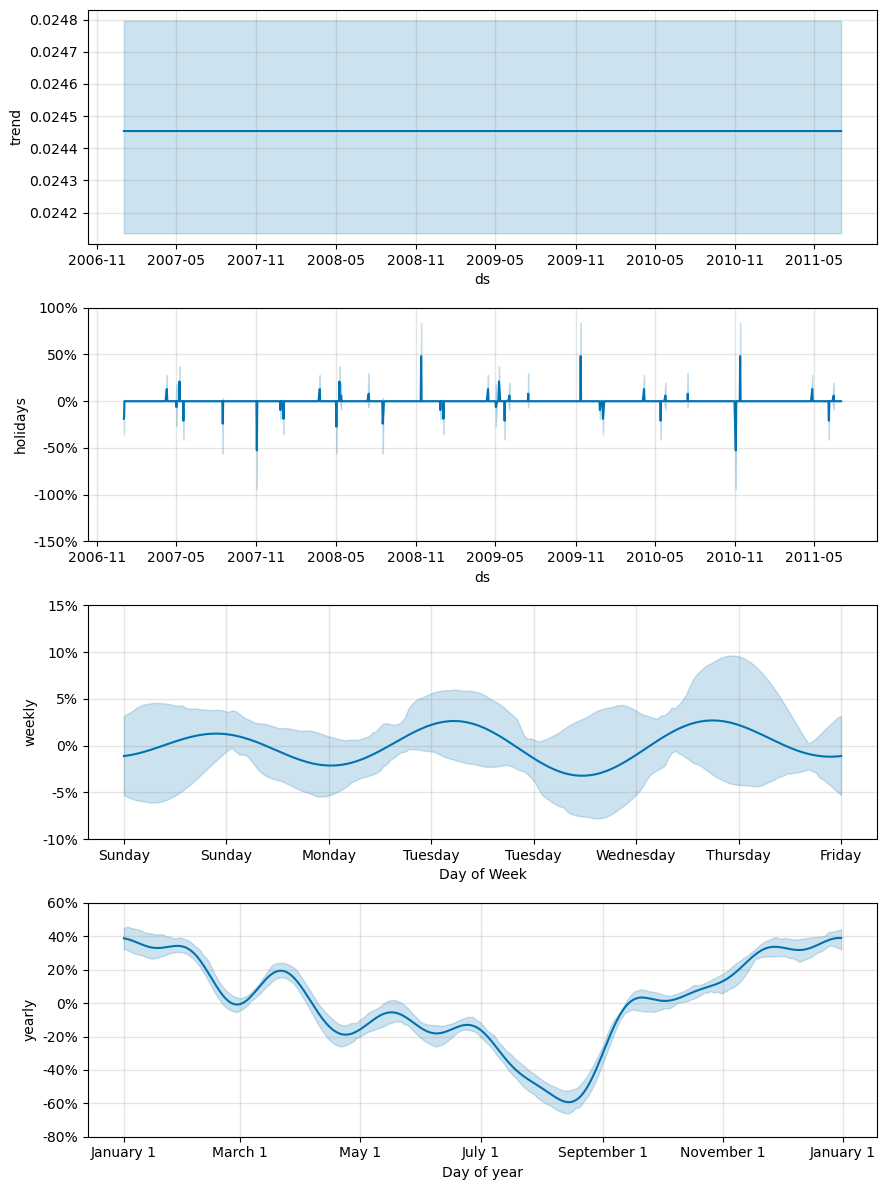

In [166]:
fig_BDay_evening_2 = m_BDay_evening.plot_components(fcst_BDay_evening)

In [167]:
fcst_BDay_evening[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
7039 2011-06-30 18:00:00  0.02        0.00        0.04
7040 2011-06-30 19:00:00  0.02        0.00        0.04
7041 2011-06-30 20:00:00  0.02        0.00        0.04
7042 2011-06-30 21:00:00  0.02        0.00        0.04
7043 2011-06-30 22:00:00  0.02        0.00        0.04

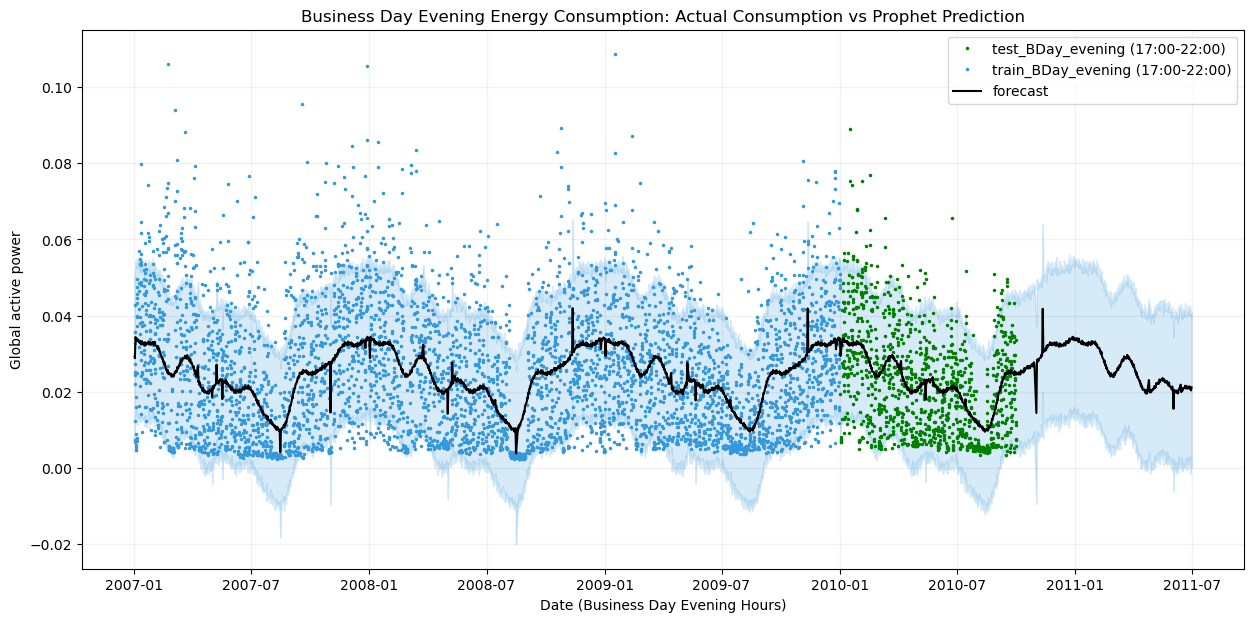

In [168]:
fig_BDay_evening_3 = plt.gcf()
fig_BDay_evening_3.set_size_inches(15, 7)
plt.plot(test_BDay_evening.ds, test_BDay_evening.y, '.', markersize=3, color='green', label = "test_BDay_evening (17:00-22:00)")
plt.plot(train_BDay_evening.ds, train_BDay_evening.y, '.', markersize=3, color='#3498db', label = "train_BDay_evening (17:00-22:00)")
plt.plot(fcst_BDay_evening.ds, fcst_BDay_evening.yhat, color='black', label = "forecast")
plt.fill_between(fcst_BDay_evening.ds, fcst_BDay_evening.yhat_lower, fcst_BDay_evening.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Business Day Evening Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (Business Day Evening Hours)')
plt.legend()
plt.show()

In [215]:
df_cv_BDay_evening = cross_validation(m_BDay_evening,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_BDay_evening_p = performance_metrics(df_cv_BDay_evening)
df_cv_BDay_evening_p.head()

horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 9 days 19:00:00 0.00  0.01 0.01  0.85   0.44   0.54      0.91
1 9 days 20:00:00 0.00  0.01 0.01  0.85   0.44   0.54      0.91
2 9 days 21:00:00 0.00  0.01 0.01  0.85   0.44   0.54      0.91
3 9 days 22:00:00 0.00  0.01 0.01  0.85   0.44   0.55      0.90
4 9 days 23:00:00 0.00  0.01 0.01  0.85   0.44   0.55      0.90

## Weekend Evening: 17:00 - 22:00

In [169]:
df_H_W = df.resample('H', on="ds").mean()
df_H_W= df_H_W.reset_index(drop=False)
df_H_W.head()

ds    y
0 2006-12-16 17:00:00 0.07
1 2006-12-16 18:00:00 0.06
2 2006-12-16 19:00:00 0.06
3 2006-12-16 20:00:00 0.05
4 2006-12-16 21:00:00 0.05

In [177]:
df_W = df_H_W[df_H_W['ds'].dt.day_of_week >= 5][df_H_W['ds'].dt.day_of_week <= 6] 
df_W.head(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1667604247.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_W = df_H_W[df_H_W['ds'].dt.day_of_week >= 5][df_H_W['ds'].dt.day_of_week <= 6]


ds    y
0   2006-12-16 17:00:00 0.07
1   2006-12-16 18:00:00 0.06
2   2006-12-16 19:00:00 0.06
3   2006-12-16 20:00:00 0.05
4   2006-12-16 21:00:00 0.05
5   2006-12-16 22:00:00 0.04
6   2006-12-16 23:00:00 0.03
7   2006-12-17 00:00:00 0.03
8   2006-12-17 01:00:00 0.06
9   2006-12-17 02:00:00 0.03
10  2006-12-17 03:00:00 0.03
11  2006-12-17 04:00:00 0.04
12  2006-12-17 05:00:00 0.03
13  2006-12-17 06:00:00 0.02
14  2006-12-17 07:00:00 0.03
15  2006-12-17 08:00:00 0.03
16  2006-12-17 09:00:00 0.04
17  2006-12-17 10:00:00 0.06
18  2006-12-17 11:00:00 0.04
19  2006-12-17 12:00:00 0.03
20  2006-12-17 13:00:00 0.03
21  2006-12-17 14:00:00 0.03
22  2006-12-17 15:00:00 0.05
23  2006-12-17 16:00:00 0.06
24  2006-12-17 17:00:00 0.06
25  2006-12-17 18:00:00 0.06
26  2006-12-17 19:00:00 0.05
27  2006-12-17 20:00:00 0.06
28  2006-12-17 21:00:00 0.05
29  2006-12-17 22:00:00 0.03
30  2006-12-17 23:00:00 0.01
151 2006-12-23 00:00:00 0.03
152 2006-12-23 01:00:00 0.03
153 2006-12-23 02:00:00 0.03
154 2006-12-23 03:00:00 0.03
155 2006-12-23 04:00:00 0.03
156 2006-12-23 05:00:00 0.04
157 2006-12-23 06:00:00 0.03
158 2006-12-23 07:00:00 0.07
159 2006-12-23 08:00:00 0.07
160 2006-12-23 09:00:00 0.05
161 2006-12-23 10:00:00 0.05
162 2006-12-23 11:00:00 0.05
163 2006-12-23 12:00:00 0.05
164 2006-12-23 13:00:00 0.06
165 2006-12-23 14:00:00 0.06
166 2006-12-23 15:00:00 0.07
167 2006-12-23 16:00:00 0.07
168 2006-12-23 17:00:00 0.09
169 2006-12-23 18:00:00 0.06

In [178]:
df_W_evening = df_W[df_W['ds'].dt.hour > 16][df_W['ds'].dt.hour < 23]
df_W_evening

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\1781263838.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_W_evening = df_W[df_W['ds'].dt.hour > 16][df_W['ds'].dt.hour < 23]


ds    y
0     2006-12-16 17:00:00 0.07
1     2006-12-16 18:00:00 0.06
2     2006-12-16 19:00:00 0.06
3     2006-12-16 20:00:00 0.05
4     2006-12-16 21:00:00 0.05
...                   ...  ...
34465 2010-11-21 18:00:00 0.01
34466 2010-11-21 19:00:00 0.00
34467 2010-11-21 20:00:00 0.01
34468 2010-11-21 21:00:00 0.02
34469 2010-11-21 22:00:00 0.02

[2472 rows x 2 columns]

In [179]:
train_W_evening=df_W_evening[(df_W_evening['ds'] >= '2007-01-01') & (df_W_evening['ds'] < '2010-01-01 00:00:00')]
test_W_evening=df_W_evening[(df_W_evening['ds'] >= '2010-01-01 00:00:00') & (df_W_evening['ds'] < '2010-10-01 00:00:00')]

In [180]:
train_W_evening.shape

(1872, 2)

In [181]:
test_W_evening.shape

(468, 2)

In [182]:
train_W_evening

ds    y
504   2007-01-06 17:00:00 0.01
505   2007-01-06 18:00:00 0.01
506   2007-01-06 19:00:00 0.03
507   2007-01-06 20:00:00 0.02
508   2007-01-06 21:00:00 0.02
...                   ...  ...
26569 2009-12-27 18:00:00 0.05
26570 2009-12-27 19:00:00 0.05
26571 2009-12-27 20:00:00 0.06
26572 2009-12-27 21:00:00 0.05
26573 2009-12-27 22:00:00 0.04

[1872 rows x 2 columns]

In [183]:
test_W_evening

ds    y
26712 2010-01-02 17:00:00 0.04
26713 2010-01-02 18:00:00 0.06
26714 2010-01-02 19:00:00 0.03
26715 2010-01-02 20:00:00 0.04
26716 2010-01-02 21:00:00 0.02
...                   ...  ...
33121 2010-09-26 18:00:00 0.03
33122 2010-09-26 19:00:00 0.02
33123 2010-09-26 20:00:00 0.04
33124 2010-09-26 21:00:00 0.03
33125 2010-09-26 22:00:00 0.01

[468 rows x 2 columns]

In [184]:
m_W_evening = Prophet(seasonality_mode='multiplicative', 
               growth='flat', 
               interval_width=0.8, 
               n_changepoints=25,
               changepoint_range=0.8,
               yearly_seasonality='auto',
               weekly_seasonality='auto',
               daily_seasonality=False,
               holidays=None,
               seasonality_prior_scale=10.0,
               holidays_prior_scale=10.0,
               changepoint_prior_scale=0.05,
               mcmc_samples=25
               ) 
m_W_evening.add_country_holidays(country_name='FRA')
m_W_evening.add_seasonality(name='weekly', period=5, fourier_order=3, mode='multiplicative')

m_W_evening.fit(train_W_evening)

15:51:27 - cmdstanpy - INFO - CmdStan installation C:\Users\pauli\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:51:27 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:51:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:51:29 - cmdstanpy - INFO - CmdStan done processing.
15:51:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

In [185]:
future_W_evening = m_W_evening.make_future_dataframe(periods = 13104, freq = 'H', include_history=True)
future_W_evening.tail(6)

ds
14970 2011-06-26 17:00:00
14971 2011-06-26 18:00:00
14972 2011-06-26 19:00:00
14973 2011-06-26 20:00:00
14974 2011-06-26 21:00:00
14975 2011-06-26 22:00:00

In [186]:
future_W_evening_final = future_W_evening.copy()
future_W_evening_final = future_W_evening_final[future_W_evening_final['ds'].dt.day_of_week >= 5][future_W_evening_final['ds'].dt.day_of_week <= 6] [future_W_evening_final['ds'].dt.hour > 16][future_W_evening_final['ds'].dt.hour < 23]
future_W_evening_final.tail(50)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20384\3115854911.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  future_W_evening_final = future_W_evening_final[future_W_evening_final['ds'].dt.day_of_week >= 5][future_W_evening_final['ds'].dt.day_of_week <= 6] [future_W_evening_final['ds'].dt.hour > 16][future_W_evening_final['ds'].dt.hour < 23]


ds
14302 2011-05-29 21:00:00
14303 2011-05-29 22:00:00
14442 2011-06-04 17:00:00
14443 2011-06-04 18:00:00
14444 2011-06-04 19:00:00
14445 2011-06-04 20:00:00
14446 2011-06-04 21:00:00
14447 2011-06-04 22:00:00
14466 2011-06-05 17:00:00
14467 2011-06-05 18:00:00
14468 2011-06-05 19:00:00
14469 2011-06-05 20:00:00
14470 2011-06-05 21:00:00
14471 2011-06-05 22:00:00
14610 2011-06-11 17:00:00
14611 2011-06-11 18:00:00
14612 2011-06-11 19:00:00
14613 2011-06-11 20:00:00
14614 2011-06-11 21:00:00
14615 2011-06-11 22:00:00
14634 2011-06-12 17:00:00
14635 2011-06-12 18:00:00
14636 2011-06-12 19:00:00
14637 2011-06-12 20:00:00
14638 2011-06-12 21:00:00
14639 2011-06-12 22:00:00
14778 2011-06-18 17:00:00
14779 2011-06-18 18:00:00
14780 2011-06-18 19:00:00
14781 2011-06-18 20:00:00
14782 2011-06-18 21:00:00
14783 2011-06-18 22:00:00
14802 2011-06-19 17:00:00
14803 2011-06-19 18:00:00
14804 2011-06-19 19:00:00
14805 2011-06-19 20:00:00
14806 2011-06-19 21:00:00
14807 2011-06-19 22:00:00
14946 2011-06-25 17:00:00
14947 2011-06-25 18:00:00
14948 2011-06-25 19:00:00
14949 2011-06-25 20:00:00
14950 2011-06-25 21:00:00
14951 2011-06-25 22:00:00
14970 2011-06-26 17:00:00
14971 2011-06-26 18:00:00
14972 2011-06-26 19:00:00
14973 2011-06-26 20:00:00
14974 2011-06-26 21:00:00
14975 2011-06-26 22:00:00

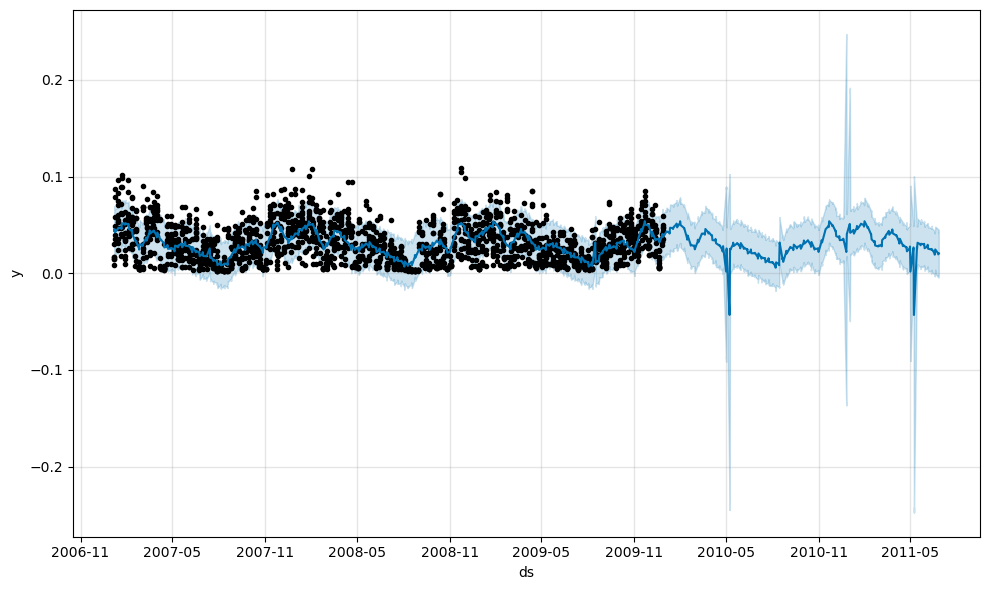

In [187]:
fcst_W_evening = m_W_evening.predict(future_W_evening_final)
fig_W_evening = m_W_evening.plot(fcst_W_evening)

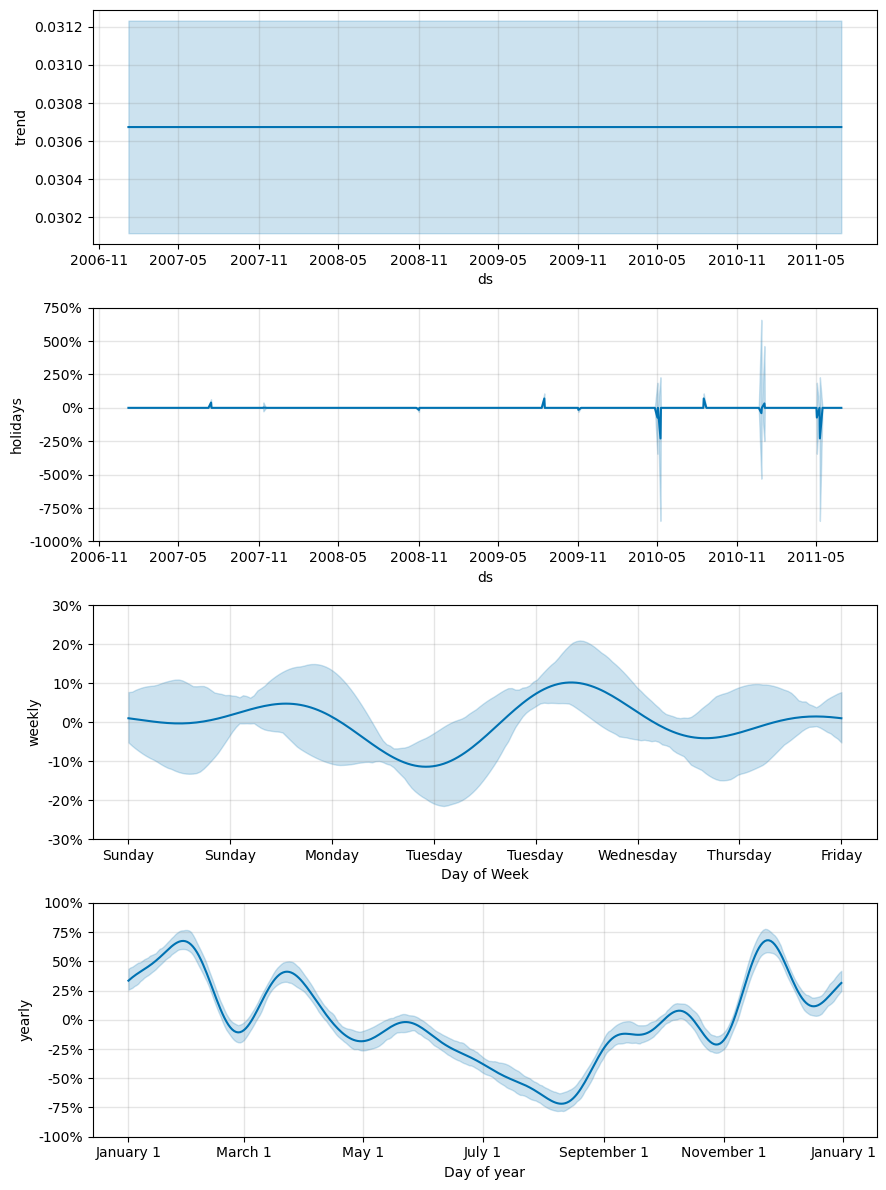

In [188]:
fig_W_evening_2 = m_W_evening.plot_components(fcst_W_evening)

In [189]:
fcst_W_evening[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds  yhat  yhat_lower  yhat_upper
2803 2011-06-26 18:00:00  0.02       -0.00        0.04
2804 2011-06-26 19:00:00  0.02       -0.00        0.05
2805 2011-06-26 20:00:00  0.02       -0.00        0.04
2806 2011-06-26 21:00:00  0.02       -0.00        0.04
2807 2011-06-26 22:00:00  0.02       -0.00        0.04

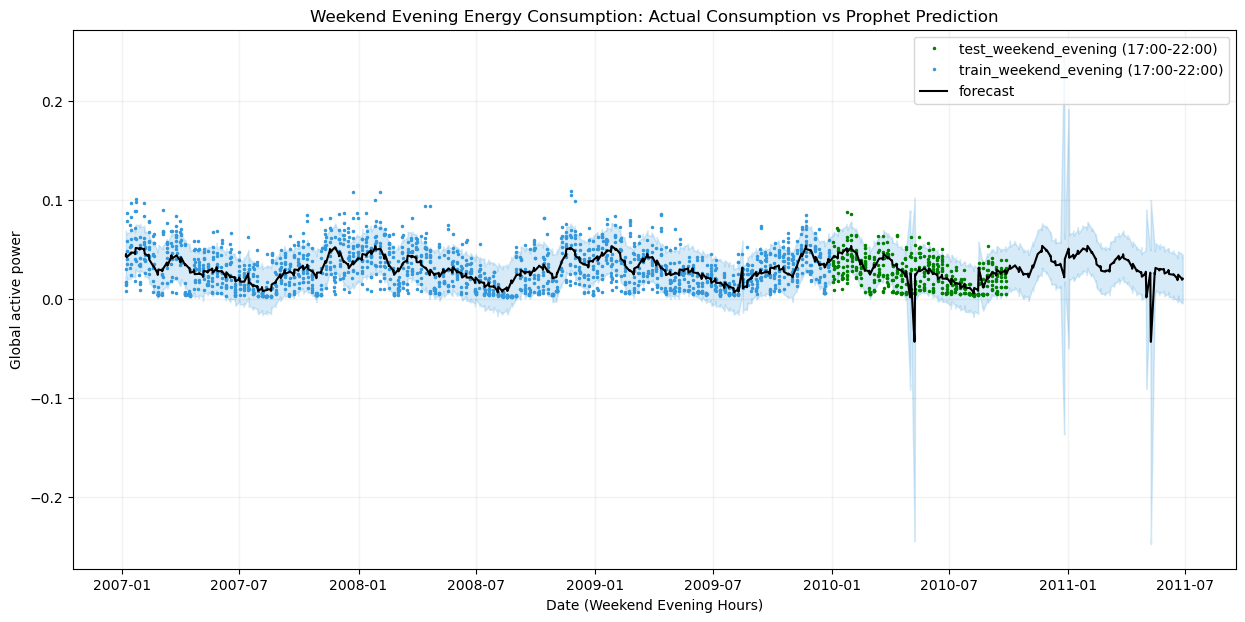

In [213]:
fig_W_evening_3 = plt.gcf()
fig_W_evening_3.set_size_inches(15, 7)
plt.plot(test_W_evening.ds, test_W_evening.y, '.', markersize=3, color='green', label = "test_weekend_evening (17:00-22:00)")
plt.plot(train_W_evening.ds, train_W_evening.y, '.', markersize=3, color='#3498db', label = "train_weekend_evening (17:00-22:00)")
plt.plot(fcst_W_evening.ds, fcst_W_evening.yhat, color='black', label = "forecast")
plt.fill_between(fcst_W_evening.ds, fcst_W_evening.yhat_lower, fcst_W_evening.yhat_upper, color=(52/255, 152/255, 219/255, 0.2))
plt.grid(color=(0, 0, 0), linestyle='-', linewidth=1, alpha=0.05)
plt.ylabel('Global active power')
plt.title('Weekend Evening Energy Consumption: Actual Consumption vs Prophet Prediction')
plt.xlabel('Date (Weekend Evening Hours)')

plt.legend()
plt.show()

In [214]:
df_cv_W_evening = cross_validation(m_W_evening,
                            initial='540 days',
                            period='30 days',
                            horizon='90 days',
                            parallel='processes')
df_cv_W_evening_p = performance_metrics(df_cv_W_evening)
df_cv_W_evening_p.head()

horizon  mse  rmse  mae  mape  mdape  smape  coverage
0 9 days 00:00:00 0.00  0.02 0.01  0.94   0.45   0.53      0.84
1 9 days 19:00:00 0.00  0.02 0.01  0.94   0.44   0.53      0.84
2 9 days 20:00:00 0.00  0.02 0.01  0.94   0.44   0.53      0.84
3 9 days 21:00:00 0.00  0.02 0.01  0.93   0.44   0.53      0.83
4 9 days 22:00:00 0.00  0.02 0.01  0.92   0.43   0.53      0.83